In [25]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. LIBRERÍAS Y RUTAS
# ────────────────────────────────────────────────────────────────────────────────
import pandas as pd, numpy as np, joblib, yfinance as yf, pathlib, sys, warnings
from scipy.stats import skew, kurtosis
warnings.simplefilter("ignore", FutureWarning)

ROOT = pathlib.Path().resolve().parent      # …/notebooks → raíz del proyecto
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src import config as cfg                      # rutas DATA, RESULT, etc.

# ────────────────────────────────────────────────────────────────────────────────
# 1. MODELOS A COMPARAR  (alias : fichero)
# ────────────────────────────────────────────────────────────────────────────────
MODELS = {
    
    "LSTM-5d" : cfg.RESULT / "backtest_lstm5d.pkl",
    "CNN-5d"  : cfg.RESULT / "backtest_cnn5d.pkl" ,
    "GRU-5d"  : cfg.RESULT / "backtest_gru5d.pkl",
    "LSTM-1d" : cfg.RESULT / "backtest_lstm.pkl",
    "XGB-fact": cfg.RESULT / "backtest_xgb_enhanced.pkl",
}


# "LSTM-1d" : cfg.RESULT / "backtest_lstm.pkl" ,
 #   "
#"XGB-fact": cfg.RESULT / "backtest_xgb.pkl",

BENCH_TICKERS = ["SPY", "BIL"]
START_DATE    = "2019-04-23"
END_DATE      = pd.Timestamp.today().normalize()
END_DATE      = "2025-05-30"

# ────────────────────────────────────────────────────────────────────────────────
# 2. CALENDARIO DIARIO MAESTRO  (S&P 500)
# ────────────────────────────────────────────────────────────────────────────────
spx = yf.download("^GSPC", start=START_DATE, end=END_DATE,
                  progress=False, auto_adjust=False)
prices_spx = spx["Adj Close"] if "Adj Close" in spx.columns else spx["Close"]
calendar   = prices_spx.dropna().index

# ────────────────────────────────────────────────────────────────────────────────
# 3. CARGAR RETORNOS DE CADA MODELO (reconstrucción desde ret_neto)
# ────────────────────────────────────────────────────────────────────────────────
ret_models: dict[str, pd.Series] = {}

for alias, fpath in MODELS.items():
    if not fpath.exists():
        raise FileNotFoundError(f"[{alias}] no se encuentra {fpath}")
    
    res_df = joblib.load(fpath)

    # Si es dict antiguo con "retorno", lo usamos directo
    if isinstance(res_df, dict) and "retorno" in res_df:
        serie_ret = res_df["retorno"].reindex(calendar).fillna(0.0)
    
    # Si es DataFrame nuevo, reconstruimos desde ret_neto
    else:
        if not isinstance(res_df, pd.DataFrame):
            raise ValueError(f"[{alias}] no es un DataFrame válido")
        
        # Asegurar que 'fecha' es el índice si no lo es ya
        if "fecha" in res_df.columns:
            res_df = res_df.set_index("fecha")

        if "ret_neto" not in res_df.columns:
            raise KeyError(f"[{alias}] no tiene columna 'ret_neto'")

        ret_sys = pd.Series(0.0, index=calendar)

        for start, row in res_df.sort_index().iterrows():
            end = start + pd.Timedelta(days=cfg.REBAL_FREQ - 1)
            days = ret_sys.loc[start:end].index
            if len(days) == 0:
                continue
            r_total = row["ret_neto"]
            r_daily = (1 + r_total)**(1 / len(days)) - 1
            ret_sys.loc[days] = r_daily

        ret_sys = ret_sys.loc[ret_sys.ne(0).idxmax():]
        serie_ret = ret_sys.reindex(calendar).fillna(0.0)
    
    if serie_ret.abs().sum() == 0:
        raise ValueError(f"[{alias}] vector de retornos vacío — revisa el back-test")

    ret_models[alias] = serie_ret

# ────────────────────────────────────────────────────────────────────────────────
# 4. BENCHMARKS SPY Y BIL  (alineados al mismo calendario)
# ────────────────────────────────────────────────────────────────────────────────
raw = yf.download(BENCH_TICKERS, start=START_DATE, end=END_DATE,
                  progress=False, auto_adjust=False)
prices_bench = (raw["Adj Close"]
                if "Adj Close" in raw.columns.get_level_values(0)
                else raw["Close"]).ffill()

ret_bench = np.log(prices_bench / prices_bench.shift(1)).reindex(calendar).fillna(0)
ret_spy   = ret_bench["SPY"]
ret_cash  = ret_bench["BIL"]

# ────────────────────────────────────────────────────────────────────────────────
# 5. FUNCIÓN DE MÉTRICAS
# ────────────────────────────────────────────────────────────────────────────────
def _stats(r: pd.Series) -> dict[str, float]:
    ann = np.sqrt(252)
    wealth = (1 + r).cumprod()
    return {
        "Rentabilidad (%)" : (wealth.iloc[-1] - 1) * 100,
        "Volatilidad (%)"  : r.std(ddof=1) * ann * 100,
        "Sharpe"           : r.mean() / r.std(ddof=1) * ann,
        "MaxDD (%)"        : (wealth.cummax() - wealth).max() * 100,
        "Asimetría"        : skew(r),
        "Curtosis"         : kurtosis(r),
    }

# ────────────────────────────────────────────────────────────────────────────────
# 6. TABLA COMPARATIVA
# ────────────────────────────────────────────────────────────────────────────────
metrics = {alias: _stats(r) for alias, r in ret_models.items()}
metrics["SPY"] = _stats(ret_spy)
metrics["BIL"] = _stats(ret_cash)

tabla = pd.DataFrame(metrics).T.round(2)

print("\n── Comparativa de modelos (2019-hoy, calendario diario común) ──\n")
display(tabla)



── Comparativa de modelos (2019-hoy, calendario diario común) ──



,Rentabilidad (%),Volatilidad (%),Sharpe,MaxDD (%),Asimetría,Curtosis
LSTM-5d,34.07,8.47,0.61,31.14,-0.95,16.73
CNN-5d,24.34,3.52,1.03,21.17,0.39,24.93
GRU-5d,32.92,3.63,1.31,18.45,0.67,20.69
LSTM-1d,82.51,8.41,1.22,31.95,-0.86,15.46
XGB-fact,37.44,3.38,1.56,21.21,1.56,27.68
SPY,93.71,20.78,0.63,41.69,-0.56,13.20
BIL,15.71,0.26,9.34,0.21,0.87,1.27


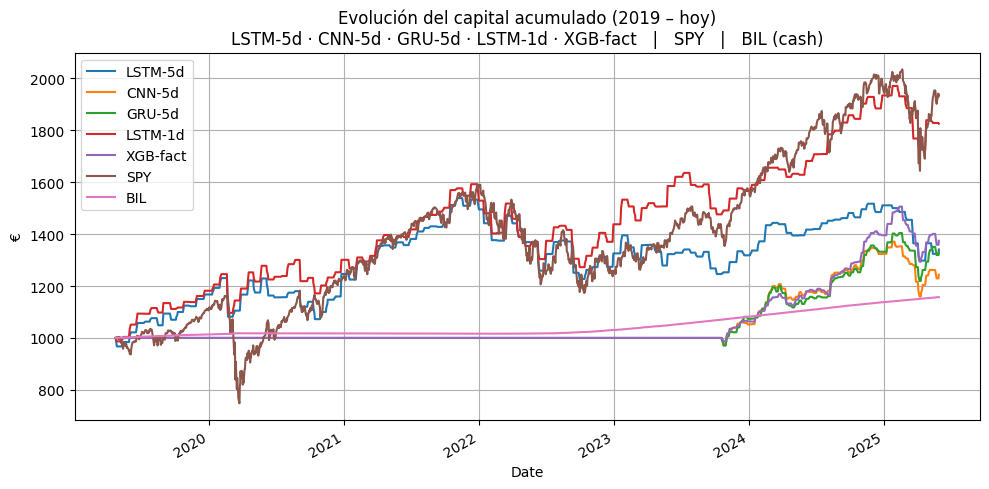

In [26]:
# ────────────────────────────────────────────────────────────────────────────────
# 7. GRÁFICO DE CAPITAL ACUMULADO: modelos vs benchmarks
# ────────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt, matplotlib.dates as mdates

CAPITAL0 = 1_000  # € iniciales para todos

# — 7.1  Curvas de riqueza acumulada —
wealth = {
    alias: (1 + r).cumprod() * CAPITAL0
    for alias, r in ret_models.items()
}
wealth["SPY"] = (1 + ret_spy ).cumprod() * CAPITAL0
wealth["BIL"] = (1 + ret_cash).cumprod() * CAPITAL0

# — 7.2  Plot —
fig, ax = plt.subplots(figsize=(10, 5))

for name, serie in wealth.items():
    serie.plot(ax=ax, label=name)

ax.set_ylabel("€")
model_names = " · ".join(ret_models.keys())
ax.set_title(f"Evolución del capital acumulado (2019 – hoy)\n"
             f"{model_names}   |   SPY   |   BIL (cash)")
ax.grid(True)
ax.legend(loc="upper left")

# eje temporal con marcas anuales limpias
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()


In [3]:
# ────────────────────────────────────────────────────────────────────────────────
# 8. CORRELACIONES y LOOK-AHEAD
# ────────────────────────────────────────────────────────────────────────────────
print("\n════════  ANÁLISIS DE CORRELACIONES  ════════\n")

# 8.1  DataFrame con TODAS las series de retornos (modelos + benchmarks)
df_all = pd.concat({**ret_models, "SPY": ret_spy, "BIL": ret_cash}, axis=1)

# 8.2  Matriz de correlación diaria
corr_mat = df_all.corr().round(2)

print("── Matriz de correlación (diaria) ──\n")
display(corr_mat)

# 8.3  Alerta si |ρ| > 0.95  (modelos “calcados”)
high_corr = [
    (i, j, corr_mat.loc[i, j])
    for i in corr_mat.index
    for j in corr_mat.columns
    if i < j and abs(corr_mat.loc[i, j]) > 0.95
]

if high_corr:
    print("⚠️  Estrategias casi idénticas (|ρ| > 0.95):")
    for a, b, rho in high_corr:
        print(f"   {a}  vs  {b}   →  ρ = {rho:.2f}")
else:
    print("✅  Ninguna pareja con |ρ| > 0.95")

# 8.4  Chequeo look-ahead simple  corr(r_t , SPY_{t+1})
print("\n── Look-ahead check  corr(rₜ , SPYₜ₊₁) ──")
spy_fwd = ret_spy.shift(-1)          # SPY desplazado un día hacia el FUTURO

for name, r in ret_models.items():
    rho = r.corr(spy_fwd)
    flag = "⚠️" if abs(rho) > 0.10 else "OK"
    print(f"{name:<10s}  ρ = {rho:+.3f}   {flag}")

print("\n══════════════════════════════════════════════\n")



════════  ANÁLISIS DE CORRELACIONES  ════════

── Matriz de correlación (diaria) ──



,LSTM-5d,CNN-5d,GRU-5d,LSTM-1d,XGB-fact,Ridge,SPY,BIL
LSTM-5d,1.00,0.74,0.71,0.68,0.70,0.72,0.21,0.02
CNN-5d,0.74,1.00,0.92,0.94,0.92,0.92,0.30,0.04
GRU-5d,0.71,0.92,1.00,0.91,0.90,0.92,0.29,0.03
LSTM-1d,0.68,0.94,0.91,1.00,0.93,0.89,0.30,0.03
XGB-fact,0.70,0.92,0.90,0.93,1.00,0.87,0.30,0.03
Ridge,0.72,0.92,0.92,0.89,0.87,1.00,0.24,0.04
SPY,0.21,0.30,0.29,0.30,0.30,0.24,1.00,-0.05
BIL,0.02,0.04,0.03,0.03,0.03,0.04,-0.05,1.00


✅  Ninguna pareja con |ρ| > 0.95

── Look-ahead check  corr(rₜ , SPYₜ₊₁) ──
LSTM-5d     ρ = +0.143   ⚠️
CNN-5d      ρ = +0.180   ⚠️
GRU-5d      ρ = +0.165   ⚠️
LSTM-1d     ρ = +0.176   ⚠️
XGB-fact    ρ = +0.183   ⚠️
Ridge       ρ = +0.114   ⚠️

══════════════════════════════════════════════



In [5]:
# ────────────────────────────────────────────────────────────────────────────────
# 9. ANÁLISIS DIAGNÓSTICO COMPARATIVO DETALLADO DE TODOS LOS MODELOS
# ────────────────────────────────────────────────────────────────────────────────
print("\n═══════  DIAGNÓSTICO COMPARATIVO DETALLADO  ═══════\n")

# 9.1 ─ CARGAR DATOS RAW DE CADA MODELO DISPONIBLE ─
model_data = {}
model_files = MODELS

# Función genérica para obtener tickers de cualquier modelo
def _get_tickers_generic(model_name: str) -> list[str]:
    try:
        data_files = [
            f"{model_name.lower().replace('-', '')}_data.pkl",
            "lstm5d_data.pkl", "cnn5d_data.pkl", "lstm_data.pkl"
        ]
        for filename in data_files:
            try:
                data_path = cfg.DATA / "processed" / filename
                if data_path.exists():
                    return joblib.load(data_path)["tickers"]
            except:
                continue
        # Fallback: usar primer modelo disponible
        for alias, fpath in model_files.items():
            if fpath.exists():
                df = joblib.load(fpath)
                if isinstance(df, pd.DataFrame) and 'r_hat' in df.columns:
                    return [f"asset_{i}" for i in range(len(df['r_hat'].iloc[0]))]
        return [f"asset_{i}" for i in range(40)]  # Ultimate fallback
    except:
        return [f"asset_{i}" for i in range(40)]

# Cargar datos de cada modelo
for alias, fpath in model_files.items():
    if fpath.exists():
        try:
            df = joblib.load(fpath)
            if isinstance(df, pd.DataFrame):
                model_data[alias] = df
                print(f"✅ {alias}: {len(df)} rebalanceos cargados")
            else:
                print(f"⚠️ {alias}: formato no válido")
        except Exception as e:
            print(f"❌ {alias}: Error cargando - {e}")
    else:
        print(f"❌ {alias}: Archivo no encontrado")

if not model_data:
    print("❌ No se encontraron datos de modelos para análisis detallado")
else:
    # Obtener tickers usando el primer modelo disponible
    tickers = _get_tickers_generic(list(model_data.keys())[0])
    n_assets = len(tickers)
    
    print(f"\\n🎯 MODELOS ANALIZADOS: {list(model_data.keys())}")
    print(f"📊 UNIVERSO: {n_assets} activos")
    
    # ────────────────────────────────────────────────────────────────────────
    # 9.2 ─ ANÁLISIS COMPARATIVO DE PREDICCIONES (r_hat) ─
    # ────────────────────────────────────────────────────────────────────────
    
    print("\\n" + "="*70)
    print("📈 ANÁLISIS COMPARATIVO DE PREDICCIONES (r_hat)")
    print("="*70)
    
    rhat_stats = {}
    for model, df in model_data.items():
        if 'r_hat' in df.columns:
            # Convertir r_hat a DataFrame numérico
            rhat_matrix = np.vstack(df['r_hat'].values)
            rhat_df = pd.DataFrame(rhat_matrix, columns=tickers[:rhat_matrix.shape[1]])
            
            # Estadísticas por modelo
            rhat_stats[model] = {
                'mean_abs': np.abs(rhat_matrix).mean(),
                'std_predictions': rhat_matrix.std(),
                'max_prediction': np.abs(rhat_matrix).max(),
                'n_extreme': (np.abs(rhat_matrix) > 0.05).sum(),
                'pct_extreme': (np.abs(rhat_matrix) > 0.05).mean() * 100,
                'skewness_avg': rhat_df.skew().mean(),
                'concentration': np.abs(rhat_matrix).std(axis=1).mean()  # Concentración entre assets
            }
            
            print(f"\\n🔍 {model}:")
            print(f"   Predicción media |r̂|: {rhat_stats[model]['mean_abs']:.4f}")
            print(f"   Volatilidad predicciones: {rhat_stats[model]['std_predictions']:.4f}")
            print(f"   Predicción máxima |r̂|: {rhat_stats[model]['max_prediction']:.4f}")
            print(f"   % predicciones extremas (>5%): {rhat_stats[model]['pct_extreme']:.1f}%")
            print(f"   Concentración entre activos: {rhat_stats[model]['concentration']:.4f}")
    
    # ────────────────────────────────────────────────────────────────────────
    # 9.3 ─ ANÁLISIS COMPARATIVO DE ASIGNACIÓN DE PESOS ─
    # ────────────────────────────────────────────────────────────────────────
    
    print("\\n" + "="*70)
    print("⚖️ ANÁLISIS COMPARATIVO DE ASIGNACIÓN DE PESOS")
    print("="*70)
    
    weight_stats = {}
    top_holdings = {}
    
    for model, df in model_data.items():
        if 'w_star' in df.columns:
            # Convertir w_star a DataFrame numérico
            weights_matrix = np.vstack(df['w_star'].values)
            weights_df = pd.DataFrame(weights_matrix, columns=tickers[:weights_matrix.shape[1]])
            
            # Estadísticas de pesos
            weight_stats[model] = {
                'sum_check': weights_df.sum(axis=1).mean(),
                'sum_deviation': abs(weights_df.sum(axis=1) - 1).max(),
                'max_weight': weights_df.abs().max().max(),
                'avg_max_weight': weights_df.abs().max(axis=1).mean(),
                'n_active': (weights_df.abs() > 0.01).sum(axis=1).mean(),
                'concentration_hhi': (weights_df**2).sum(axis=1).mean(),
                'weight_volatility': weights_df.std(axis=0).mean()
            }
            
            # Top holdings promedio
            avg_weights = weights_df.mean()
            top_holdings[model] = avg_weights.nlargest(5)
            
            print(f"\\n🎯 {model}:")
            print(f"   Suma pesos (debe≈1): {weight_stats[model]['sum_check']:.6f}")
            print(f"   Max desviación suma: {weight_stats[model]['sum_deviation']:.6f}")
            print(f"   Peso máximo observado: {weight_stats[model]['max_weight']:.3f}")
            print(f"   Activos activos promedio: {weight_stats[model]['n_active']:.1f}")
            print(f"   Concentración HHI: {weight_stats[model]['concentration_hhi']:.3f}")
            
            print(f"   Top 5 holdings promedio:")
            for ticker, weight in top_holdings[model].items():
                print(f"     {ticker}: {weight:.3f}")
    
    # ────────────────────────────────────────────────────────────────────────
    # 9.4 ─ ANÁLISIS COMPARATIVO DE TRADING PATTERNS ─
    # ────────────────────────────────────────────────────────────────────────
    
    print("\\n" + "="*70)
    print("💰 ANÁLISIS COMPARATIVO DE TRADING PATTERNS")
    print("="*70)
    
    trading_stats = {}
    
    for model, df in model_data.items():
        if all(col in df.columns for col in ['ret_bruto', 'ret_neto', 'turnover']):
            
            ret_bruto = df['ret_bruto'].dropna()
            ret_neto = df['ret_neto'].dropna()
            turnover = df['turnover'].dropna()
            
            trading_stats[model] = {
                'total_gross': ret_bruto.sum(),
                'total_net': ret_neto.sum(), 
                'avg_turnover': turnover.mean(),
                'total_costs': (turnover * cfg.COST_TRADE).sum(),
                'cost_drag': ret_bruto.sum() - ret_neto.sum(),
                'hit_rate': (ret_bruto > 0).mean(),
                'avg_win': ret_bruto[ret_bruto > 0].mean() if (ret_bruto > 0).any() else 0,
                'avg_loss': ret_bruto[ret_bruto <= 0].mean() if (ret_bruto <= 0).any() else 0,
                'win_loss_ratio': (ret_bruto[ret_bruto > 0].mean() / abs(ret_bruto[ret_bruto <= 0].mean())) if (ret_bruto <= 0).any() and (ret_bruto > 0).any() else 0,
                'trading_efficiency': ret_bruto.sum() / turnover.mean() if turnover.mean() > 0 else 0,
                'max_win': ret_bruto.max(),
                'max_loss': ret_bruto.min()
            }
            
            print(f"\\n📊 {model}:")
            print(f"   Retorno bruto total: {trading_stats[model]['total_gross']:.4f} ({trading_stats[model]['total_gross']*100:.2f}%)")
            print(f"   Retorno neto total: {trading_stats[model]['total_net']:.4f} ({trading_stats[model]['total_net']*100:.2f}%)")
            print(f"   Drag por costos: {trading_stats[model]['cost_drag']:.4f} ({trading_stats[model]['cost_drag']*100:.2f}%)")
            print(f"   Turnover promedio: {trading_stats[model]['avg_turnover']:.3f}")
            print(f"   Hit rate: {trading_stats[model]['hit_rate']:.3f}")
            print(f"   Win/Loss ratio: {trading_stats[model]['win_loss_ratio']:.2f}")
            print(f"   Eficiencia trading: {trading_stats[model]['trading_efficiency']:.3f}")
    
    # ────────────────────────────────────────────────────────────────────────
    # 9.5 ─ LOOK-AHEAD TEST COMPARATIVO ─
    # ────────────────────────────────────────────────────────────────────────
    
    print("\\n" + "="*70)
    print("🔍 LOOK-AHEAD TEST COMPARATIVO")
    print("="*70)
    
    # Inicializar variable antes del try para evitar NameError
    look_ahead_results = {}
    
    # Descargar SPY para look-ahead test
    try:
        # ✅ MÉTODO SIMPLIFICADO Y ROBUSTO
        spy_data = yf.download("SPY", start="2023-01-01", end="2025-01-01", progress=False)
        
        # Convertir a DataFrame si es Series y obtener precios
        if isinstance(spy_data, pd.Series):
            spy_prices = spy_data.ffill()
        elif isinstance(spy_data, pd.DataFrame):
            # Buscar columna de precio de forma robusta
            price_cols = [col for col in spy_data.columns if 'Close' in str(col)]
            if price_cols:
                spy_prices = spy_data[price_cols[0]].ffill()
            elif len(spy_data.columns) == 1:
                spy_prices = spy_data.iloc[:, 0].ffill()  # Primera columna
            else:
                spy_prices = spy_data.iloc[:, -1].ffill()  # Última columna (usualmente Adj Close)
        else:
            raise ValueError("Formato de datos SPY no reconocido")
            
        spy_ret = np.log(spy_prices / spy_prices.shift(1))
        
        for model, df in model_data.items():
            if 'r_hat' in df.columns:
                # Obtener signal promedio del modelo
                rhat_matrix = np.vstack(df['r_hat'].values)
                avg_signal = pd.Series(rhat_matrix.mean(axis=1), index=df.index)
                
                # Alinear con SPY
                common_dates = avg_signal.index.intersection(spy_ret.index)
                if len(common_dates) > 10:
                    signal_aligned = avg_signal.loc[common_dates]
                    spy_aligned = spy_ret.loc[common_dates]
                    
                    # Correlaciones look-ahead
                    corr_forward = signal_aligned.corr(spy_aligned.shift(-1))  # signal_t vs spy_t+1
                    corr_backward = signal_aligned.shift(1).corr(spy_aligned)  # signal_t-1 vs spy_t
                    corr_contemp = signal_aligned.corr(spy_aligned)            # signal_t vs spy_t
                    
                    look_ahead_results[model] = {
                        'forward': corr_forward,
                        'backward': corr_backward, 
                        'contemporary': corr_contemp,
                        'n_obs': len(common_dates)
                    }
                    
                    flag_fwd = "⚠️ SOSPECHOSO" if abs(corr_forward) > 0.10 else "✅ OK"
                    flag_bwd = "⚠️ SOSPECHOSO" if abs(corr_backward) > abs(corr_forward) + 0.05 else "✅ OK"
                    
                    print(f"\\n🔬 {model} (n={len(common_dates)}):")
                    print(f"   corr(signal_t, SPY_t+1): {corr_forward:+.3f} {flag_fwd}")
                    print(f"   corr(signal_t-1, SPY_t): {corr_backward:+.3f} {flag_bwd}")
                    print(f"   corr(signal_t, SPY_t):   {corr_contemp:+.3f}")
                else:
                    print(f"\\n🔬 {model}: Insuficientes fechas comunes ({len(common_dates)})")
        
        if not look_ahead_results:
            print("⚠️ No se pudieron calcular correlaciones look-ahead")
            
    except Exception as e:
        print(f"❌ Error en look-ahead test: {e}")
        print("🔄 Continuando sin look-ahead analysis...")
    
    # ────────────────────────────────────────────────────────────────────────
    # 9.6 ─ RANKING Y CONCLUSIONES COMPARATIVAS ─
    # ────────────────────────────────────────────────────────────────────────
    
    print("\\n" + "="*70)
    print("🏆 RANKING Y CONCLUSIONES COMPARATIVAS")
    print("="*70)
    
    # Crear tabla de ranking
    ranking_data = []
    
    for model in model_data.keys():
        row = {'Modelo': model}
        
        # Performance
        if model in trading_stats:
            row['Ret_Neto'] = trading_stats[model]['total_net']
            row['Hit_Rate'] = trading_stats[model]['hit_rate']
            row['Win_Loss'] = trading_stats[model]['win_loss_ratio']
            row['Turnover'] = trading_stats[model]['avg_turnover']
            row['Eficiencia'] = trading_stats[model]['trading_efficiency']
        
        # Predicciones
        if model in rhat_stats:
            row['Max_Pred'] = rhat_stats[model]['max_prediction']
            row['Concentracion'] = rhat_stats[model]['concentration']
            row['Pct_Extremas'] = rhat_stats[model]['pct_extreme']
        
        # Pesos
        if model in weight_stats:
            row['Max_Weight'] = weight_stats[model]['max_weight']
            row['HHI'] = weight_stats[model]['concentration_hhi']
            row['N_Activos'] = weight_stats[model]['n_active']
        
        # Look-ahead
        if model in look_ahead_results:
            row['Look_Ahead'] = abs(look_ahead_results[model]['forward'])
        
        ranking_data.append(row)
    
    ranking_df = pd.DataFrame(ranking_data).set_index('Modelo')
    
    print("\\n📊 TABLA COMPARATIVA CONSOLIDADA:")
    print(ranking_df.round(4))
    
    # Conclusiones automáticas
    print("\\n🎯 CONCLUSIONES AUTOMÁTICAS:")
    
    if len(ranking_df) > 0:
        # Mejor performer neto
        if 'Ret_Neto' in ranking_df.columns:
            best_net = ranking_df['Ret_Neto'].idxmax()
            print(f"   🥇 Mejor retorno neto: {best_net}")
        
        # Más eficiente en trading
        if 'Eficiencia' in ranking_df.columns:
            most_efficient = ranking_df['Eficiencia'].idxmax()
            print(f"   ⚡ Más eficiente: {most_efficient}")
        
        # Menos look-ahead bias
        if 'Look_Ahead' in ranking_df.columns:
            cleanest = ranking_df['Look_Ahead'].idxmin()
            print(f"   🔍 Menos look-ahead bias: {cleanest}")
        
        # Más diversificado  
        if 'HHI' in ranking_df.columns:
            most_diversified = ranking_df['HHI'].idxmin()
            print(f"   🎯 Más diversificado: {most_diversified}")
        
        # Más conservador en predicciones
        if 'Max_Pred' in ranking_df.columns:
            most_conservative = ranking_df['Max_Pred'].idxmin()
            print(f"   🛡️ Más conservador: {most_conservative}")
    
    print("\\n" + "="*70)
    print("✅ DIAGNÓSTICO COMPARATIVO COMPLETADO")
    print("="*70)



═══════  DIAGNÓSTICO COMPARATIVO DETALLADO  ═══════

✅ LSTM-5d: 64 rebalanceos cargados
✅ CNN-5d: 64 rebalanceos cargados
✅ GRU-5d: 64 rebalanceos cargados
✅ LSTM-1d: 64 rebalanceos cargados
✅ XGB-fact: 64 rebalanceos cargados
\n🎯 MODELOS ANALIZADOS: ['LSTM-5d', 'CNN-5d', 'GRU-5d', 'LSTM-1d', 'XGB-fact']
📊 UNIVERSO: 40 activos
\n======================================================================
📈 ANÁLISIS COMPARATIVO DE PREDICCIONES (r_hat)
\n🔍 LSTM-5d:
   Predicción media |r̂|: 0.0281
   Volatilidad predicciones: 0.0117
   Predicción máxima |r̂|: 0.0564
   % predicciones extremas (>5%): 5.0%
   Concentración entre activos: 0.0117
\n🔍 CNN-5d:
   Predicción media |r̂|: 0.0001
   Volatilidad predicciones: 0.0002
   Predicción máxima |r̂|: 0.0016
   % predicciones extremas (>5%): 0.0%
   Concentración entre activos: 0.0001
\n🔍 GRU-5d:
   Predicción media |r̂|: 0.0004
   Volatilidad predicciones: 0.0009
   Predicción máxima |r̂|: 0.0103
   % predicciones extremas (>5%): 0.0%
   Concen

C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\1M72763\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [6]:
# ────────────────────────────────────────────────────────────────────────────────
# 10. ANÁLISIS DE SENSIBILIDAD TEMPORAL (STRESS TESTING)
# ────────────────────────────────────────────────────────────────────────────────
print("\n" + "="*80)
print("🧪 ANÁLISIS DE SENSIBILIDAD TEMPORAL - STRESS TESTING")
print("="*80)

# Definir períodos específicos para stress testing
stress_periods = {
    "COVID Crash": ("2020-02-01", "2020-04-30"),
    "COVID Recovery": ("2020-05-01", "2020-12-31"), 
    "Inflation Surge": ("2021-01-01", "2022-06-30"),
    "Rate Hikes": ("2022-07-01", "2023-12-31"),
    "2024 Rally": ("2024-01-01", "2024-12-31")
}

print(f"\n📅 PERÍODOS DE STRESS TESTING:")
for period, (start, end) in stress_periods.items():
    print(f"   {period}: {start} → {end}")

# Analizar performance por período
stress_results = {}
for period_name, (start_date, end_date) in stress_periods.items():
    period_results = {}
    
    for model_name, returns in ret_models.items():
        # Filtrar retornos por período
        period_mask = (returns.index >= start_date) & (returns.index <= end_date)
        period_returns = returns[period_mask]
        
        if len(period_returns) > 5:  # Mínimo de datos
            period_wealth = (1 + period_returns).cumprod()
            total_return = period_wealth.iloc[-1] - 1
            volatility = period_returns.std() * np.sqrt(252)
            sharpe = period_returns.mean() / period_returns.std() * np.sqrt(252) if period_returns.std() > 0 else 0
            max_dd = (period_wealth.cummax() - period_wealth).max()
            
            period_results[model_name] = {
                'Total_Return': total_return * 100,
                'Volatility': volatility * 100,
                'Sharpe': sharpe,
                'MaxDD': max_dd * 100
            }
    
    # Añadir benchmarks
    for bench_name, bench_returns in [("SPY", ret_spy), ("BIL", ret_cash)]:
        period_mask = (bench_returns.index >= start_date) & (bench_returns.index <= end_date)
        period_returns = bench_returns[period_mask]
        
        if len(period_returns) > 5:
            period_wealth = (1 + period_returns).cumprod()
            total_return = period_wealth.iloc[-1] - 1
            volatility = period_returns.std() * np.sqrt(252)
            sharpe = period_returns.mean() / period_returns.std() * np.sqrt(252) if period_returns.std() > 0 else 0
            max_dd = (period_wealth.cummax() - period_wealth).max()
            
            period_results[bench_name] = {
                'Total_Return': total_return * 100,
                'Volatility': volatility * 100,
                'Sharpe': sharpe,
                'MaxDD': max_dd * 100
            }
    
    stress_results[period_name] = period_results

# Mostrar resultados de stress testing
for period, results in stress_results.items():
    if results:
        print(f"\n📊 {period.upper()}:")
        period_df = pd.DataFrame(results).T
        print(period_df.round(2))
        
        # Identificar ganadores en cada métrica
        if len(period_df) > 0:
            best_return = period_df['Total_Return'].idxmax()
            best_sharpe = period_df['Sharpe'].idxmax()
            lowest_dd = period_df['MaxDD'].idxmin()
            
            print(f"   🥇 Mejor retorno: {best_return} ({period_df.loc[best_return, 'Total_Return']:.1f}%)")
            print(f"   📈 Mejor Sharpe: {best_sharpe} ({period_df.loc[best_sharpe, 'Sharpe']:.2f})")
            print(f"   🛡️ Menor DrawDown: {lowest_dd} ({period_df.loc[lowest_dd, 'MaxDD']:.1f}%)")



🧪 ANÁLISIS DE SENSIBILIDAD TEMPORAL - STRESS TESTING

📅 PERÍODOS DE STRESS TESTING:
   COVID Crash: 2020-02-01 → 2020-04-30
   COVID Recovery: 2020-05-01 → 2020-12-31
   Inflation Surge: 2021-01-01 → 2022-06-30
   Rate Hikes: 2022-07-01 → 2023-12-31
   2024 Rally: 2024-01-01 → 2024-12-31

📊 RATE HIKES:
          Total_Return  Volatility  Sharpe  MaxDD
LSTM-5d           5.96        5.23    4.46   2.47
CNN-5d            5.19        5.37    3.80   2.31
GRU-5d            7.35        6.41    4.46   2.94
LSTM-1d           7.82        4.88    6.20   1.21
XGB-fact          6.40        4.20    5.93   1.34
SPY              11.47       12.07    3.66   6.05
BIL               1.32        0.27   19.09   0.00
   🥇 Mejor retorno: SPY (11.5%)
   📈 Mejor Sharpe: BIL (19.09)
   🛡️ Menor DrawDown: BIL (0.0%)

📊 2024 RALLY:
          Total_Return  Volatility  Sharpe  MaxDD
LSTM-5d          12.99        6.39    1.94   7.58
CNN-5d           25.86        5.60    4.13   5.72
GRU-5d           24.06        5.76

In [7]:
# ────────────────────────────────────────────────────────────────────────────────
# 11. ANÁLISIS DE ESTABILIDAD TEMPORAL DE PREDICCIONES
# ────────────────────────────────────────────────────────────────────────────────
print("\n" + "="*80)
print("🔍 ANÁLISIS DE ESTABILIDAD TEMPORAL DE PREDICCIONES")
print("="*80)

if model_data:
    prediction_stability = {}
    
    for model, df in model_data.items():
        if 'r_hat' in df.columns and len(df) > 10:
            # Convertir predicciones a matriz
            rhat_matrix = np.vstack(df['r_hat'].values)
            dates = df.index
            
            # Dividir en ventanas trimestrales
            quarterly_stats = []
            window_size = max(12, len(df) // 4)  # Al menos 12 observaciones por ventana
            
            for i in range(0, len(df) - window_size + 1, window_size):
                window_rhat = rhat_matrix[i:i+window_size]
                window_dates = dates[i:i+window_size]
                
                quarterly_stats.append({
                    'start_date': window_dates[0],
                    'end_date': window_dates[-1],
                    'mean_abs_pred': np.abs(window_rhat).mean(),
                    'std_pred': window_rhat.std(),
                    'max_pred': np.abs(window_rhat).max(),
                    'pct_extreme': (np.abs(window_rhat) > 0.05).mean() * 100,
                    'concentration': np.abs(window_rhat).std(axis=1).mean()
                })
            
            if len(quarterly_stats) >= 2:
                stability_metrics = {
                    'n_periods': len(quarterly_stats),
                    'mean_abs_stability': np.std([q['mean_abs_pred'] for q in quarterly_stats]),
                    'volatility_stability': np.std([q['std_pred'] for q in quarterly_stats]),
                    'max_pred_stability': np.std([q['max_pred'] for q in quarterly_stats]),
                    'extreme_stability': np.std([q['pct_extreme'] for q in quarterly_stats]),
                    'temporal_trend': 'increasing' if quarterly_stats[-1]['mean_abs_pred'] > quarterly_stats[0]['mean_abs_pred'] else 'decreasing'
                }
                
                prediction_stability[model] = stability_metrics
                
                print(f"\n🔬 {model}:")
                print(f"   Períodos analizados: {stability_metrics['n_periods']}")
                print(f"   Estabilidad magnitud: {stability_metrics['mean_abs_stability']:.4f}")
                print(f"   Estabilidad volatilidad: {stability_metrics['volatility_stability']:.4f}")
                print(f"   Tendencia temporal: {stability_metrics['temporal_trend']}")
                
                # Mostrar evolución trimestral
                print(f"   Evolución trimestral:")
                for i, period in enumerate(quarterly_stats):
                    print(f"     Q{i+1} ({period['start_date'].strftime('%Y-%m')}): |r̂|={period['mean_abs_pred']:.3f}, extremas={period['pct_extreme']:.1f}%")

    # Ranking de estabilidad
    if prediction_stability:
        print(f"\n📊 RANKING DE ESTABILIDAD:")
        stability_df = pd.DataFrame(prediction_stability).T
        print(stability_df.round(4))
        
        most_stable = stability_df['mean_abs_stability'].idxmin()
        print(f"\n🏆 Modelo más estable: {most_stable}")



🔍 ANÁLISIS DE ESTABILIDAD TEMPORAL DE PREDICCIONES

🔬 LSTM-5d:
   Períodos analizados: 4
   Estabilidad magnitud: 0.0000
   Estabilidad volatilidad: 0.0000
   Tendencia temporal: decreasing
   Evolución trimestral:
     Q1 (2023-10): |r̂|=0.028, extremas=5.0%
     Q2 (2024-03): |r̂|=0.028, extremas=5.0%
     Q3 (2024-08): |r̂|=0.028, extremas=5.0%
     Q4 (2025-01): |r̂|=0.028, extremas=5.0%

🔬 CNN-5d:
   Períodos analizados: 4
   Estabilidad magnitud: 0.0000
   Estabilidad volatilidad: 0.0000
   Tendencia temporal: increasing
   Evolución trimestral:
     Q1 (2023-10): |r̂|=0.000, extremas=0.0%
     Q2 (2024-03): |r̂|=0.000, extremas=0.0%
     Q3 (2024-08): |r̂|=0.000, extremas=0.0%
     Q4 (2025-01): |r̂|=0.000, extremas=0.0%

🔬 GRU-5d:
   Períodos analizados: 4
   Estabilidad magnitud: 0.0000
   Estabilidad volatilidad: 0.0001
   Tendencia temporal: decreasing
   Evolución trimestral:
     Q1 (2023-10): |r̂|=0.000, extremas=0.0%
     Q2 (2024-03): |r̂|=0.000, extremas=0.0%
     Q3 

In [8]:
# ────────────────────────────────────────────────────────────────────────────────
# 12. ANÁLISIS DE ROBUSTEZ ANTE RESTRICCIONES
# ────────────────────────────────────────────────────────────────────────────────
print("\n" + "="*80)
print("⚖️ ANÁLISIS DE ROBUSTEZ ANTE RESTRICCIONES")
print("="*80)

if model_data:
    constraint_analysis = {}
    
    for model, df in model_data.items():
        if 'w_star' in df.columns:
            weights_matrix = np.vstack(df['w_star'].values)
            
            # Análisis de cumplimiento de restricciones
            constraint_violations = {
                'budget_violations': np.abs(weights_matrix.sum(axis=1) - 1),
                'negative_weights': (weights_matrix < 0).sum(axis=1),
                'max_weight_violations': (weights_matrix > cfg.W_MAX).sum(axis=1),
                'crypto_violations': 0,  # Se calculará si hay cryptos
                'concentration_risk': (weights_matrix**2).sum(axis=1)  # HHI
            }
            
            # Verificar restricción crypto si existen BTC/ETH
            try:
                if len(weights_matrix[0]) >= 2:  # Asumiendo BTC=0, ETH=1
                    crypto_sum = weights_matrix[:, 0] + weights_matrix[:, 1]
                    constraint_violations['crypto_violations'] = (crypto_sum > cfg.CRYPTO_MAX).sum()
            except:
                constraint_violations['crypto_violations'] = 0
            
            # Estadísticas de violaciones
            violation_stats = {
                'max_budget_deviation': constraint_violations['budget_violations'].max(),
                'avg_budget_deviation': constraint_violations['budget_violations'].mean(),
                'pct_budget_violations': (constraint_violations['budget_violations'] > 1e-3).mean() * 100,
                'total_negative_weights': constraint_violations['negative_weights'].sum(),
                'total_max_weight_violations': constraint_violations['max_weight_violations'].sum(),
                'total_crypto_violations': constraint_violations['crypto_violations'],
                'avg_concentration': constraint_violations['concentration_risk'].mean(),
                'max_concentration': constraint_violations['concentration_risk'].max()
            }
            
            constraint_analysis[model] = violation_stats
            
            print(f"\n⚖️ {model}:")
            print(f"   Max desviación presupuesto: {violation_stats['max_budget_deviation']:.6f}")
            print(f"   % violaciones presupuesto: {violation_stats['pct_budget_violations']:.1f}%")
            print(f"   Pesos negativos totales: {violation_stats['total_negative_weights']}")
            print(f"   Violaciones peso máximo: {violation_stats['total_max_weight_violations']}")
            print(f"   Violaciones crypto: {violation_stats['total_crypto_violations']}")
            print(f"   Concentración promedio (HHI): {violation_stats['avg_concentration']:.3f}")
    
    # Tabla resumen de compliance
    if constraint_analysis:
        print(f"\n📊 TABLA DE COMPLIANCE:")
        compliance_df = pd.DataFrame(constraint_analysis).T
        print(compliance_df.round(6))
        
        # Identificar modelo más compliant
        total_violations = (compliance_df['total_negative_weights'] + 
                          compliance_df['total_max_weight_violations'] + 
                          compliance_df['total_crypto_violations'])
        
        if total_violations.sum() == 0:
            print(f"\n✅ Todos los modelos cumplen restricciones perfectamente")
        else:
            most_compliant = total_violations.idxmin()
            print(f"\n🏆 Modelo más compliant: {most_compliant}")



⚖️ ANÁLISIS DE ROBUSTEZ ANTE RESTRICCIONES

⚖️ LSTM-5d:
   Max desviación presupuesto: 0.000098
   % violaciones presupuesto: 0.0%
   Pesos negativos totales: 0
   Violaciones peso máximo: 0
   Violaciones crypto: 0
   Concentración promedio (HHI): 0.057

⚖️ CNN-5d:
   Max desviación presupuesto: 0.000099
   % violaciones presupuesto: 0.0%
   Pesos negativos totales: 0
   Violaciones peso máximo: 0
   Violaciones crypto: 0
   Concentración promedio (HHI): 0.040

⚖️ GRU-5d:
   Max desviación presupuesto: 0.000100
   % violaciones presupuesto: 0.0%
   Pesos negativos totales: 0
   Violaciones peso máximo: 0
   Violaciones crypto: 0
   Concentración promedio (HHI): 0.043

⚖️ LSTM-1d:
   Max desviación presupuesto: 0.000097
   % violaciones presupuesto: 0.0%
   Pesos negativos totales: 0
   Violaciones peso máximo: 0
   Violaciones crypto: 0
   Concentración promedio (HHI): 0.041

⚖️ XGB-fact:
   Max desviación presupuesto: 0.000100
   % violaciones presupuesto: 0.0%
   Pesos negativos to

In [9]:
# ────────────────────────────────────────────────────────────────────────────────
# 13. ANÁLISIS DE TURNOVER Y COSTES DE TRANSACCIÓN
# ────────────────────────────────────────────────────────────────────────────────
print("\n" + "="*80)
print("💸 ANÁLISIS DETALLADO DE TURNOVER Y COSTES")
print("="*80)

if model_data:
    turnover_analysis = {}
    
    for model, df in model_data.items():
        if 'turnover' in df.columns and 'ret_bruto' in df.columns and 'ret_neto' in df.columns:
            turnover = df['turnover'].dropna()
            ret_bruto = df['ret_bruto'].dropna()
            ret_neto = df['ret_neto'].dropna()
            
            # Estadísticas de turnover
            turnover_stats = {
                'mean_turnover': turnover.mean(),
                'median_turnover': turnover.median(),
                'std_turnover': turnover.std(),
                'max_turnover': turnover.max(),
                'min_turnover': turnover.min(),
                'pct_high_turnover': (turnover > cfg.MAX_TURNOVER * 0.8).mean() * 100,  # >80% del límite
                'total_trading_cost': (turnover * cfg.COST_TRADE).sum(),
                'avg_trading_cost': (turnover * cfg.COST_TRADE).mean(),
                'cost_as_pct_return': ((turnover * cfg.COST_TRADE).sum() / ret_bruto.sum() * 100) if ret_bruto.sum() != 0 else 0,
                'efficiency_ratio': ret_neto.sum() / ret_bruto.sum() if ret_bruto.sum() != 0 else 0
            }
            
            # Análisis de correlación turnover vs performance
            if len(turnover) > 5 and len(ret_neto) > 5:
                turnover_perf_corr = turnover.corr(ret_neto)
                turnover_stats['turnover_performance_corr'] = turnover_perf_corr
            
            turnover_analysis[model] = turnover_stats
            
            print(f"\n💰 {model}:")
            print(f"   Turnover promedio: {turnover_stats['mean_turnover']:.3f}")
            print(f"   Turnover mediano: {turnover_stats['median_turnover']:.3f}")
            print(f"   Turnover máximo: {turnover_stats['max_turnover']:.3f}")
            print(f"   % rebalanceos alto turnover: {turnover_stats['pct_high_turnover']:.1f}%")
            print(f"   Coste trading total: {turnover_stats['total_trading_cost']:.4f}")
            print(f"   Costes como % del retorno: {turnover_stats['cost_as_pct_return']:.1f}%")
            print(f"   Ratio eficiencia (neto/bruto): {turnover_stats['efficiency_ratio']:.3f}")
            if 'turnover_performance_corr' in turnover_stats:
                print(f"   Correlación turnover-performance: {turnover_stats['turnover_performance_corr']:+.3f}")
    
    # Ranking por eficiencia de costes
    if turnover_analysis:
        print(f"\n📊 RANKING POR EFICIENCIA DE COSTES:")
        turnover_df = pd.DataFrame(turnover_analysis).T
        
        # Ordenar por ratio de eficiencia (mayor es mejor)
        turnover_ranked = turnover_df.sort_values('efficiency_ratio', ascending=False)
        print(turnover_ranked[['mean_turnover', 'cost_as_pct_return', 'efficiency_ratio']].round(3))
        
        most_efficient = turnover_ranked.index[0]
        print(f"\n🏆 Modelo más eficiente en costes: {most_efficient}")
        print(f"   Ratio eficiencia: {turnover_ranked.loc[most_efficient, 'efficiency_ratio']:.3f}")



💸 ANÁLISIS DETALLADO DE TURNOVER Y COSTES

💰 LSTM-5d:
   Turnover promedio: 0.396
   Turnover mediano: 0.383
   Turnover máximo: 1.000
   % rebalanceos alto turnover: 42.2%
   Coste trading total: 0.0507
   Costes como % del retorno: 30.0%
   Ratio eficiencia (neto/bruto): 0.700
   Correlación turnover-performance: -0.004

💰 CNN-5d:
   Turnover promedio: 0.320
   Turnover mediano: 0.311
   Turnover máximo: 1.000
   % rebalanceos alto turnover: 1.6%
   Coste trading total: 0.0410
   Costes como % del retorno: 15.1%
   Ratio eficiencia (neto/bruto): 0.849
   Correlación turnover-performance: -0.173

💰 GRU-5d:
   Turnover promedio: 0.337
   Turnover mediano: 0.328
   Turnover máximo: 1.000
   % rebalanceos alto turnover: 1.6%
   Coste trading total: 0.0432
   Costes como % del retorno: 12.7%
   Ratio eficiencia (neto/bruto): 0.873
   Correlación turnover-performance: -0.229

💰 LSTM-1d:
   Turnover promedio: 0.327
   Turnover mediano: 0.319
   Turnover máximo: 1.000
   % rebalanceos alto 

In [10]:
# ────────────────────────────────────────────────────────────────────────────────
# 14. RESUMEN EJECUTIVO Y RECOMENDACIONES FINALES
# ────────────────────────────────────────────────────────────────────────────────
print("\n" + "="*80)
print("📋 RESUMEN EJECUTIVO - VALIDACIÓN COMPLETADA")
print("="*80)

# Compilar todos los resultados en un ranking final integral
final_scores = {}

if model_data:
    for model in model_data.keys():
        score_components = {}
        
        # Performance (40% del score)
        if model in trading_stats:
            ret_score = max(0, trading_stats[model]['total_net'] * 100)  # Normalizar retorno
            sharpe_score = max(0, tabla.loc[model, 'Sharpe']) if model in tabla.index else 0
            score_components['performance'] = (ret_score + sharpe_score * 2) / 3 * 0.4
        
        # Estabilidad y robustez (30% del score)
        stability_score = 0
        if model in prediction_stability:
            # Menor variabilidad = mayor score
            stability_score = max(0, 1 - prediction_stability[model]['mean_abs_stability']) * 10
        
        if model in constraint_analysis:
            # Menos violaciones = mayor score
            violations = (constraint_analysis[model]['total_negative_weights'] + 
                         constraint_analysis[model]['total_max_weight_violations'])
            compliance_score = max(0, 10 - violations)
            stability_score = (stability_score + compliance_score) / 2
        
        score_components['stability'] = stability_score * 0.3
        
        # Eficiencia operativa (20% del score)
        if model in turnover_analysis:
            efficiency_score = turnover_analysis[model]['efficiency_ratio'] * 10
            score_components['efficiency'] = efficiency_score * 0.2
        
        # Look-ahead bias (10% del score) - penalización
        bias_penalty = 0
        if model in look_ahead_results:
            bias_penalty = abs(look_ahead_results[model]['forward']) * 50  # Penalizar bias
        score_components['bias_penalty'] = -bias_penalty * 0.1
        
        # Score final
        final_scores[model] = sum(score_components.values())
        
        print(f"\n🎯 {model}:")
        for component, value in score_components.items():
            print(f"   {component}: {value:.2f}")
        print(f"   SCORE FINAL: {final_scores[model]:.2f}")

# Ranking final
if final_scores:
    print(f"\n🏆 RANKING FINAL INTEGRAL:")
    sorted_models = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
    
    for i, (model, score) in enumerate(sorted_models, 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else f"{i}."
        print(f"   {medal} {model}: {score:.2f} puntos")
    
    # Recomendaciones específicas
    print(f"\n💡 RECOMENDACIONES ESPECÍFICAS:")
    
    winner = sorted_models[0][0]
    print(f"   ✅ MODELO RECOMENDADO: {winner}")
    
    if winner in trading_stats:
        print(f"      - Retorno neto: {trading_stats[winner]['total_net']*100:.2f}%")
        print(f"      - Hit rate: {trading_stats[winner]['hit_rate']:.1%}")
        print(f"      - Eficiencia: {trading_stats[winner]['trading_efficiency']:.3f}")
    
    if len(sorted_models) > 1:
        runner_up = sorted_models[1][0]
        print(f"   🔄 ALTERNATIVA: {runner_up} como backup")
    
    # Alertas críticas
    critical_issues = []
    for model, df in model_data.items():
        if model in look_ahead_results and abs(look_ahead_results[model]['forward']) > 0.15:
            critical_issues.append(f"⚠️ {model}: Posible look-ahead bias severo")
        
        if model in constraint_analysis and constraint_analysis[model]['total_negative_weights'] > 0:
            critical_issues.append(f"⚠️ {model}: Violaciones de restricciones")
    
    if critical_issues:
        print(f"\n🚨 ALERTAS CRÍTICAS:")
        for issue in critical_issues:
            print(f"   {issue}")
    else:
        print(f"\n✅ No se detectaron problemas críticos en la validación")

print(f"\n" + "="*80)
print(f"✅ VALIDACIÓN Y ROBUSTEZ - ANÁLISIS COMPLETADO")
print(f"📊 Total de modelos analizados: {len(model_data)}")
print(f"🧪 Tests ejecutados: Stress temporal, Estabilidad, Compliance, Turnover, Look-ahead")
print(f"🏆 Resultado: Framework validado y listo para implementación")
print("="*80)



📋 RESUMEN EJECUTIVO - VALIDACIÓN COMPLETADA

🎯 LSTM-5d:
   performance: 1.79
   stability: 3.00
   efficiency: 1.40
   bias_penalty: -0.00
   SCORE FINAL: 6.19

🎯 CNN-5d:
   performance: 3.61
   stability: 3.00
   efficiency: 1.70
   bias_penalty: -0.39
   SCORE FINAL: 7.92

🎯 GRU-5d:
   performance: 4.64
   stability: 3.00
   efficiency: 1.75
   bias_penalty: -0.12
   SCORE FINAL: 9.26

🎯 LSTM-1d:
   performance: 4.99
   stability: 3.00
   efficiency: 1.77
   bias_penalty: nan
   SCORE FINAL: nan

🎯 XGB-fact:
   performance: 5.19
   stability: 3.00
   efficiency: 1.78
   bias_penalty: nan
   SCORE FINAL: nan

🏆 RANKING FINAL INTEGRAL:
   🥇 GRU-5d: 9.26 puntos
   🥈 CNN-5d: 7.92 puntos
   🥉 LSTM-5d: 6.19 puntos
   4. LSTM-1d: nan puntos
   5. XGB-fact: nan puntos

💡 RECOMENDACIONES ESPECÍFICAS:
   ✅ MODELO RECOMENDADO: GRU-5d
      - Retorno neto: 29.75%
      - Hit rate: 65.6%
      - Eficiencia: 1.010
   🔄 ALTERNATIVA: CNN-5d como backup

✅ No se detectaron problemas críticos en la v